In [2]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from datetime import date, timedelta
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN

In [3]:
#setting a random set
tf.random.set_seed(1234)

In [4]:
# #Total vaccine
# df_vaccine = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/country_data/India.csv")
# df_vaccine.index=pd.to_datetime(df_vaccine.date)
# df_vaccine.drop(columns=['location','vaccine','source_url','total_vaccinations','date','people_fully_vaccinated','total_boosters'],inplace=True)
# df_vaccine

In [5]:
# #Total daily people vaccinated
# daily_people_vaccinated=pd.DataFrame()
# daily_people_vaccinated['people_vaccinated'] = df_vaccine["people_vaccinated"].diff().fillna(0).astype('int64')
# daily_people_vaccinated

In [6]:
# daily_people_vaccinated =daily_people_vaccinated[:455]
# daily_people_vaccinated

In [7]:
# daily_people_vaccinated.to_csv('daily_vaccination.csv')

In [8]:
#reading the dataset
daily_people_vaccinated = pd.read_csv('daily_vaccination.csv')
daily_people_vaccinated.set_index('date',inplace = True)
daily_people_vaccinated.index=pd.to_datetime(daily_people_vaccinated.index)
daily_people_vaccinated

,people_vaccinated
date,
2021-01-15,0
2021-01-16,191181
2021-01-17,33120
2021-01-18,229748
2021-01-19,220786
...,...
2022-04-26,559685
2022-04-27,525457
2022-04-28,465152


In [9]:
daily_people_vaccinated.describe()

,people_vaccinated
count,4.550000e+02
mean,2.204752e+06
std,1.965244e+06
min,0.000000e+00
25%,6.722945e+05
50%,1.777637e+06
75%,3.031644e+06
max,1.266605e+07


In [10]:
print(daily_people_vaccinated.skew())
print(daily_people_vaccinated.kurt())
print(daily_people_vaccinated.median())

people_vaccinated    1.608325
dtype: float64
people_vaccinated    3.556441
dtype: float64
people_vaccinated    1777637.0
dtype: float64


In [11]:
#defining a function to plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Daily Deaths', {'fontsize': 12})

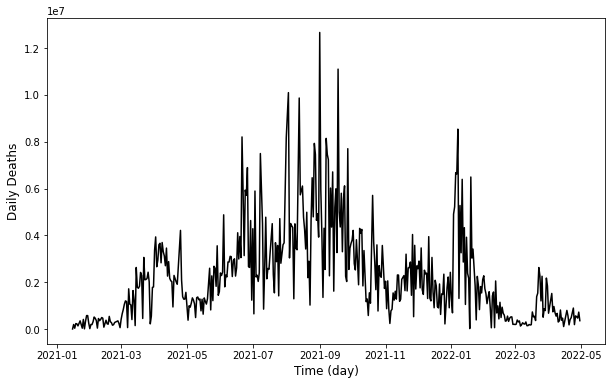

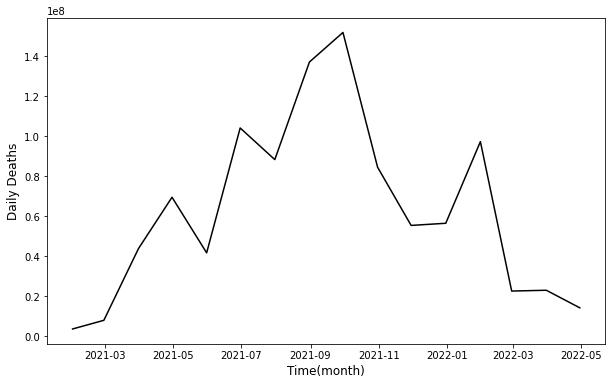

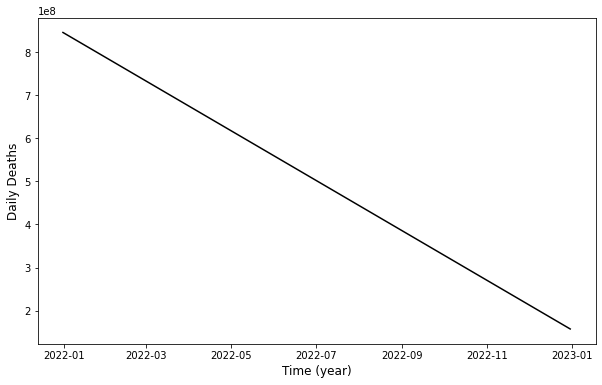

In [12]:
#analysing the data daily, monthly and yearly
dataset = daily_people_vaccinated.copy()
timeseries(daily_people_vaccinated.index, dataset['people_vaccinated'], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['people_vaccinated'], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['people_vaccinated'], 
           'Time (year)')

In [13]:
dataset

,people_vaccinated,month,year
date,,,
2021-01-15,0,1,2021
2021-01-16,191181,1,2021
2021-01-17,33120,1,2021
2021-01-18,229748,1,2021
2021-01-19,220786,1,2021
...,...,...,...
2022-04-26,559685,4,2022
2022-04-27,525457,4,2022
2022-04-28,465152,4,2022


In [14]:
# Split train data and test data
train_size = int(len(daily_people_vaccinated)*0.8)
#iloc is used to find a subset of the dataframe based on their index position
train_data = daily_people_vaccinated.iloc[:train_size]
test_data = daily_people_vaccinated.iloc[train_size:]

In [15]:
train_data

,people_vaccinated
date,
2021-01-15,0
2021-01-16,191181
2021-01-17,33120
2021-01-18,229748
2021-01-19,220786
...,...
2022-01-20,3027610
2022-01-21,3412936
2022-01-22,2633157


In [16]:
len(train_data),len(test_data)

(364, 91)

In [17]:
##scale or normalize data as the data is too skewed
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [18]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)

Now

1). X_train - This includes your all independent variables,these will be used to train the model, also as we have specified the test_size = 0.2, this means 80% of observations from your complete data will be used to train/fit the model and rest 20% will be used to test the model.

2). X_test - This is remaining 20% portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.

3). y_train - This is your dependent variable which needs to be predicted by this model, this includes category labels against your independent variables, we need to specify our dependent variable while training/fitting the model.

4). y_test - This data has category labels for your test data, these labels will be used to test the accuracy between actual and predicted categories.

In [19]:
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (334, 30, 1)
y_train.shape:  (334, 1)
X_test.shape:  (61, 30, 1)
y_test.shape:  (61, 1)


In [20]:
# Create RNN model
def create_rnn(units):
    model = Sequential()
    # Input layer
    model.add(SimpleRNN (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(SimpleRNN(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_rnn = create_rnn(64)

In [21]:
# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_lstm = create_lstm(64)

In [22]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True, activation='relu'), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units,activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation='relu'))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [23]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, activation='relu',
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units,activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1,activation='relu')) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [24]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history


In [25]:
history_rnn = fit_model(model_rnn)

Epoch 1/100
17/17 [==============================] - 6s 79ms/step - loss: 0.0221 - val_loss: 0.0172
Epoch 2/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0241 - val_loss: 0.0177
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0203 - val_loss: 0.0155
Epoch 4/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0170 - val_loss: 0.0152
Epoch 5/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0189 - val_loss: 0.0151
Epoch 7/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0167 - val_loss: 0.0151
Epoch 8/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0177 - val_loss: 0.0158
Epoch 9/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0189 - val_loss: 0.0154
Epoch 10/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0181 - val_loss: 0.0149

In [26]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
17/17 [==============================] - 7s 98ms/step - loss: 0.0323 - val_loss: 0.0253
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0264 - val_loss: 0.0177
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0200 - val_loss: 0.0191
Epoch 4/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0195 - val_loss: 0.0185
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0174 - val_loss: 0.0184
Epoch 6/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0185 - val_loss: 0.0184
Epoch 7/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0178 - val_loss: 0.0185
Epoch 8/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0173 - val_loss: 0.0186
Epoch 9/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0174 - val_loss: 0.0185
Epoch 10/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0175 - val_loss: 0.0185

In [27]:
history_bilstm = fit_model(model_bilstm)

Epoch 1/100
17/17 [==============================] - 12s 157ms/step - loss: 0.0308 - val_loss: 0.0242
Epoch 2/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0270 - val_loss: 0.0177
Epoch 3/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0191 - val_loss: 0.0193
Epoch 4/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0199 - val_loss: 0.0177
Epoch 5/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 6/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0186 - val_loss: 0.0177
Epoch 7/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 8/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 9/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0170 - val_loss: 0.0175
Epoch 10/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0160 - val_loss: 0.01

In [28]:
history_gru = fit_model(model_gru)

Epoch 1/100
17/17 [==============================] - 7s 97ms/step - loss: 0.0362 - val_loss: 0.0184
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0226 - val_loss: 0.0176
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0224 - val_loss: 0.0169
Epoch 4/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0208 - val_loss: 0.0163
Epoch 5/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0186 - val_loss: 0.0166
Epoch 6/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 7/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0157 - val_loss: 0.0166
Epoch 8/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 9/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 10/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0162 - val_loss: 0.0167

In [29]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [30]:
def plot_loss (history1, model_name1,history2, model_name2,history3, model_name3,history4, model_name4):
    plt.figure(figsize = (10, 6))
    plt.plot(history1.history['loss'])
    #plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['loss'])
    #plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['loss'])
    #plt.plot(history3.history['val_loss'])
    plt.plot(history4.history['loss'])
    #plt.plot(history4.history['val_loss'])
    plt.title('Comparision of Train loss')
    plt.legend(['RNN', 'LSTM', 'Bi-LSTM', 'GRU'],loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('epoch')

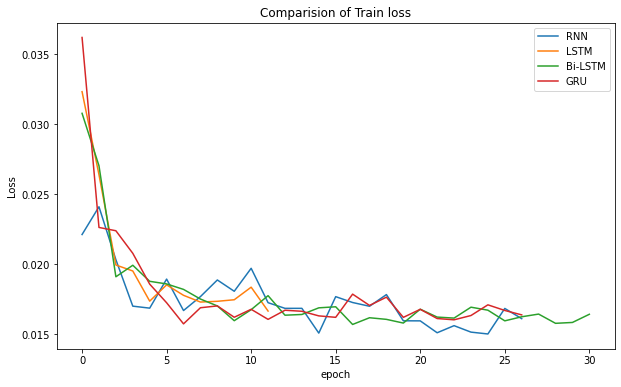

In [31]:
plot_loss (history_rnn, 'RNN',history_lstm, 'LSTM',history_bilstm, 'Bi-LSTM',history_gru, 'GRU')

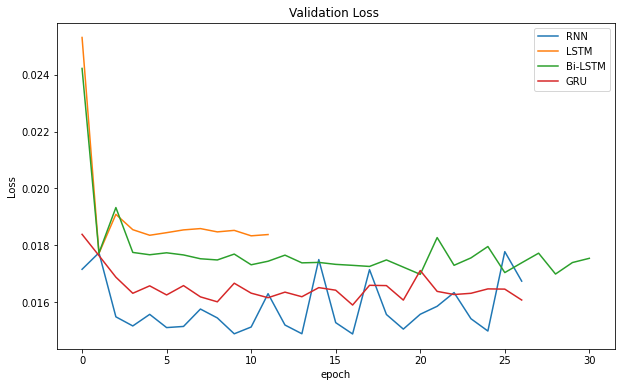

In [32]:
#plotting the validation loss
plt.figure(figsize = (10, 6))
plt.plot(history_rnn.history['val_loss'])
plt.plot(history_lstm.history['val_loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Validation Loss ' )
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['RNN', 'LSTM','Bi-LSTM','GRU'], loc='upper right')

In [33]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

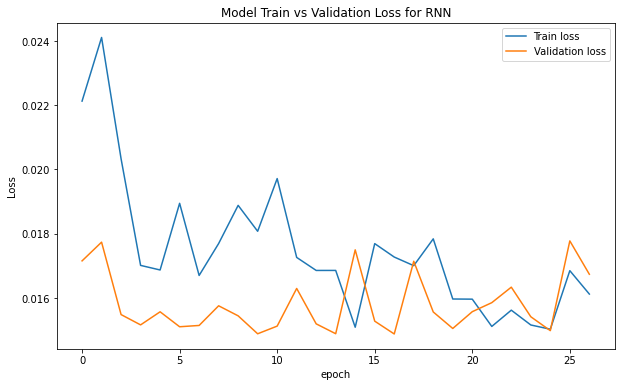

In [34]:
plot_loss(history_rnn,'RNN')

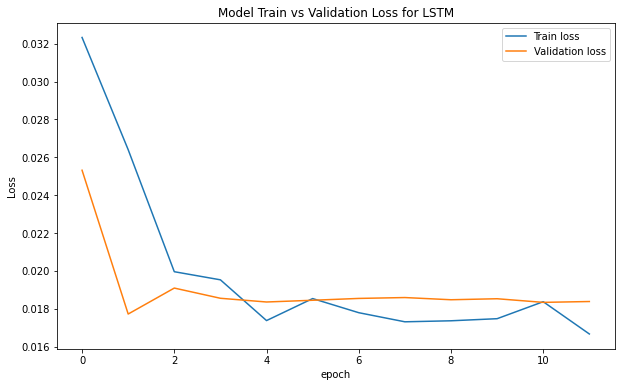

In [35]:
plot_loss (history_lstm, 'LSTM')

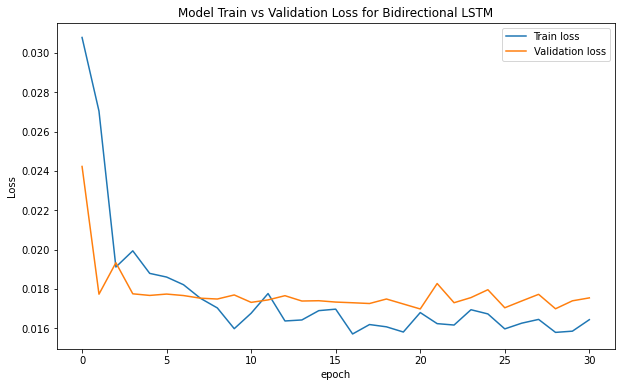

In [36]:
plot_loss (history_bilstm, 'Bidirectional LSTM')

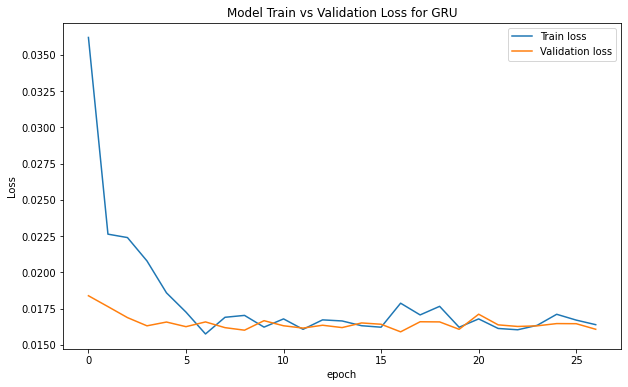

In [37]:
plot_loss (history_gru, 'GRU')

In [38]:
# Make modeling
def modeling(model):
    modeling = model.predict(X_train)
    modeling = scaler.inverse_transform(modeling)
    return modeling
modeling_rnn = modeling(model_rnn)
modeling_lstm = modeling(model_lstm)
modeling_bilstm = modeling(model_bilstm)
modeling_gru = modeling(model_gru)

11/11 [==============================] - 1s 15ms/step


In [39]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_rnn = prediction(model_rnn)
prediction_lstm = prediction(model_lstm)
prediction_bilstm = prediction(model_bilstm)
prediction_gru = prediction(model_gru)

2/2 [==============================] - 0s 15ms/step


In [40]:
# Plot train data vs modeling
def plot_model(modeling, model_name, y_train):
    plt.figure(figsize=(10, 6))
    range_future = daily_people_vaccinated.index[:len(modeling)]
    plt.plot(range_future, np.array(y_train), 
             label='Train   data')
    plt.plot(range_future, 
             np.array(modeling),label='Modeling')
    plt.title('Train data vs modeling for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily People Vaccinated')

Text(0, 0.5, 'Total Daily Vaccination')

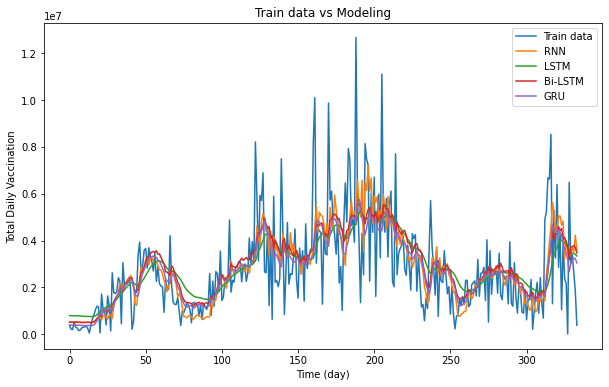

In [41]:
# Plot train data vs modeling
plt.figure(figsize=(10, 6))
range_future = len(modeling_rnn)
plt.plot(np.arange(range_future), np.array(y_train),label='Train data')
plt.plot(np.arange(range_future), np.array(modeling_rnn),label='RNN')
plt.plot(np.arange(range_future), np.array(modeling_lstm),label='LSTM')
plt.plot(np.arange(range_future), np.array(modeling_bilstm),label='Bi-LSTM')
plt.plot(np.arange(range_future), np.array(modeling_gru),label='GRU')
plt.title('Train data vs Modeling')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Vaccination')

Text(0, 0.5, 'Total Daily Vaccination')

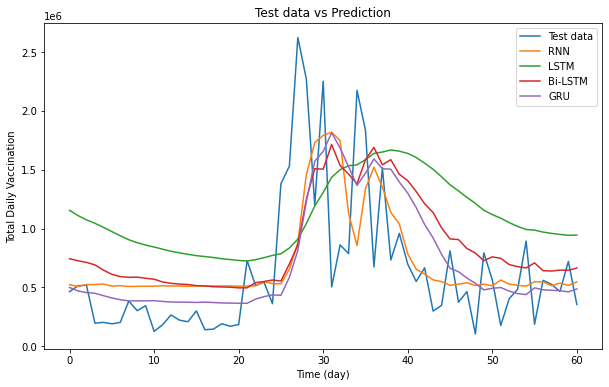

In [42]:
# Plot test data vs prediction
plt.figure(figsize=(10, 6))
range_future = len(prediction_rnn)
plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
plt.plot(np.arange(range_future), np.array(prediction_rnn),label='RNN')
plt.plot(np.arange(range_future), np.array(prediction_lstm),label='LSTM')
plt.plot(np.arange(range_future), np.array(prediction_bilstm),label='Bi-LSTM')
plt.plot(np.arange(range_future), np.array(prediction_gru),label='GRU')
plt.title('Test data vs Prediction')
plt.legend(loc='upper right')
plt.xlabel('Time (day)')
plt.ylabel('Total Daily Vaccination')

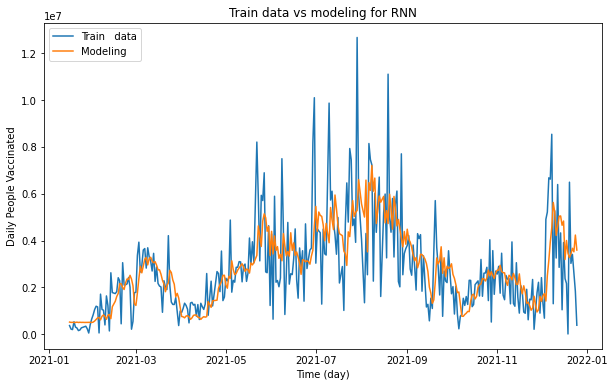

In [43]:
plot_model(modeling_rnn, 'RNN', y_train)

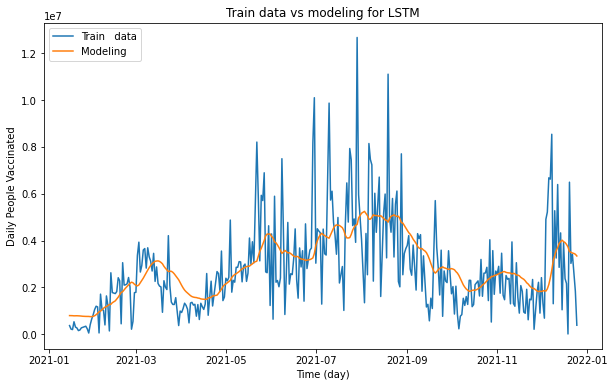

In [44]:
plot_model(modeling_lstm, 'LSTM', y_train)

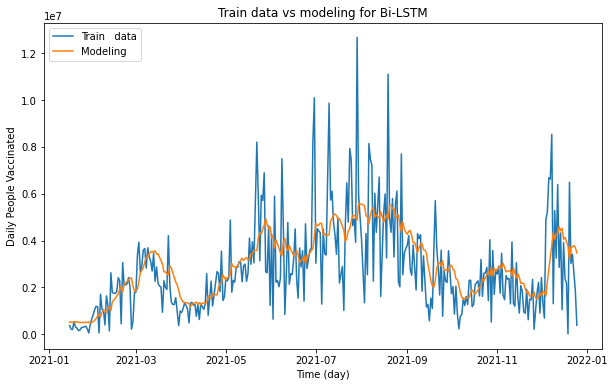

In [45]:
plot_model(modeling_bilstm, 'Bi-LSTM', y_train)

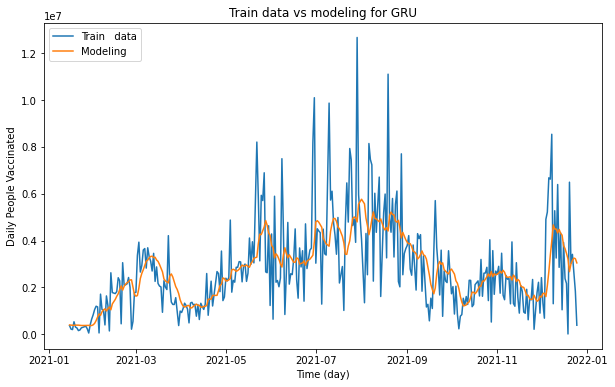

In [46]:
plot_model(modeling_gru, 'GRU', y_train)

In [47]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily People Vaccinated')

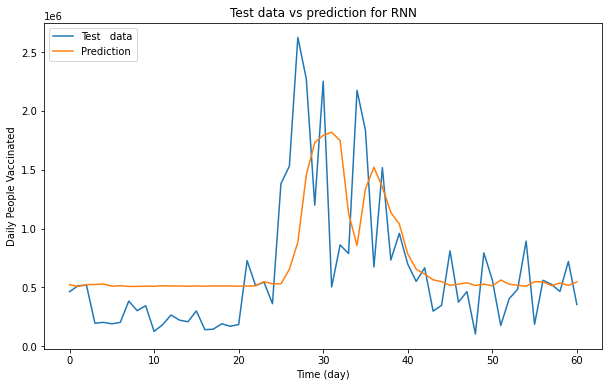

In [48]:
plot_future(prediction_rnn, 'RNN', y_test)

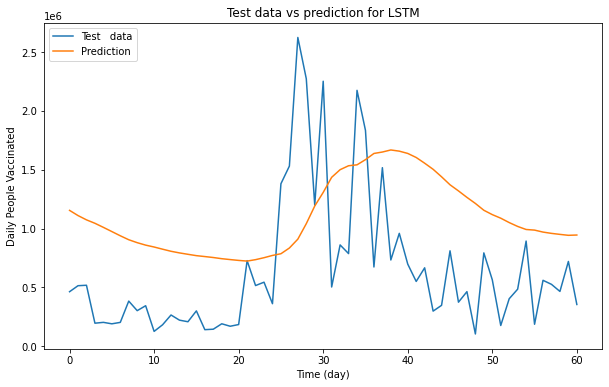

In [49]:
plot_future(prediction_lstm, 'LSTM', y_test)

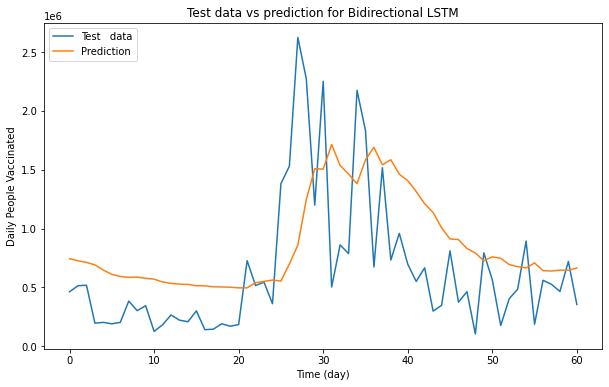

In [50]:
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

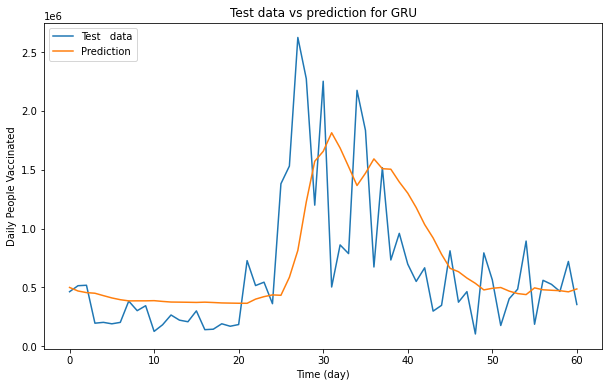

In [51]:
plot_future(prediction_gru, 'GRU', y_test)

In [52]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error

def evaluate_prediction(predictions, actual, model_name):
  global mse, rmse, mae, mda, ev, mape
  errors = predictions - actual
  #m=(abs(predictions)+abs(actual))/2
  mse = mean_squared_error(actual,predictions)
  rmse = mean_squared_error(actual, predictions, squared = False)
  mae = mean_absolute_error(actual, predictions)
  mda = np.mean((np.sign(actual[1:] - actual[:-1])==np.sign(predictions[1:] - predictions[:-1])).astype(int))
  ev = explained_variance_score(actual, predictions)
  #mape = mean_absolute_percentage_error(actual, predictions)
  #smape= np.mean(errors/m)
  print(model_name + ':')
  print('Mean Absolute Error: {:.4f}'.format(mae))
  print('Mean Square Error: {:.4f}'.format(mse))
  print('Root Mean Square Error: {:.4f}'.format(rmse))
  print('Mean Directional Accuracy: {:.4f}'.format(mda))
  print('Explained Variance Score: {:.4f}'.format(ev))
  # the value when some element of the y_true is zero is arbitrarily high because of the division by epsilon
  #print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
  print('')

evaluate_prediction(prediction_rnn, y_test, 'Simple RNN')
E1=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
E2=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
E3=[mae,mse,rmse,mda,ev]
evaluate_prediction(prediction_gru, y_test, 'GRU')
E4=[mae,mse,rmse,mda,ev]

Simple RNN:
Mean Absolute Error: 338038.9385
Mean Square Error: 228865645817.1760
Root Mean Square Error: 478399.0445
Mean Directional Accuracy: 0.4500
Explained Variance Score: 0.3303

LSTM:
Mean Absolute Error: 650237.3576
Mean Square Error: 516677168982.0929
Root Mean Square Error: 718802.5939
Mean Directional Accuracy: 0.4333
Explained Variance Score: 0.0643

Bidirectional LSTM:
Mean Absolute Error: 438772.0195
Mean Square Error: 296684620793.7053
Root Mean Square Error: 544687.6360
Mean Directional Accuracy: 0.3167
Explained Variance Score: 0.2511

GRU:
Mean Absolute Error: 351371.6936
Mean Square Error: 248503133678.2734
Root Mean Square Error: 498500.8863
Mean Directional Accuracy: 0.3000
Explained Variance Score: 0.2714



In [53]:
data_dict={'Model': ['RNN', 'LSTM', 'BiLSTM', 'GRU'],
             'mae': [E1[0],E2[0],E3[0],E4[0]],
             'mse': [E1[1],E2[1],E3[1],E4[1]],
           'rmse':[E1[2],E2[2],E3[2],E4[2]],
           'mda':[E1[3],E2[3],E3[3],E4[3]],
           'ev':[E1[4],E2[4],E3[4],E4[4]]}
           #'mape':[E1[5],E2[5],E3[5],E4[5]]}
          
a=pd.DataFrame(data=data_dict)
a

,Model,mae,mse,rmse,mda,ev
0,RNN,338038.938525,2.288656e+11,478399.044540,0.450000,0.330322
1,LSTM,650237.357582,5.166772e+11,718802.593889,0.433333,0.064300
2,BiLSTM,438772.019467,2.966846e+11,544687.635984,0.316667,0.251106
3,GRU,351371.693648,2.485031e+11,498500.886336,0.300000,0.271384


In [54]:
#creating dataset for forecasting
def create_dataset (X, look_back, n):
    Xs = []
    for i in range(n): #put the number of days to predict
        v = X[i:i+look_back]
        Xs.append(v)

    return np.array(Xs)

In [55]:
# function for forecasting new data
def forecasted(model,model_name, new_data):
    forecasted = model.predict(new_data)
    forecasted = scaler.inverse_transform(forecasted)
    print("Forecasted for",model_name,":")
    print(forecasted)
    return forecasted

In [56]:
#Forecasting 1 day vaccination
new_data= create_dataset(test_scaled,30,1)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (1, 30, 1)
1/1 [==============================] - 0s 52ms/step
Forecasted for RNN :
[[522512.]]
1/1 [==============================] - 0s 46ms/step
Forecasted for LSTM :
[[1154254.5]]
1/1 [==============================] - 0s 56ms/step
Forecasted for Bi-LSTM :
[[742964.9]]
1/1 [==============================] - 0s 35ms/step
Forecasted for GRU :
[[498981.84]]


In [57]:
#Forecasting 3 day vaccination
new_data= create_dataset(test_scaled,30,3)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

X_30.shape:  (3, 30, 1)
1/1 [==============================] - 0s 42ms/step
Forecasted for RNN :
[[522512.  ]
 [507493.94]
 [522974.72]]
1/1 [==============================] - 0s 48ms/step
Forecasted for LSTM :
[[1154254.5]
 [1110110.2]
 [1073692.5]]
1/1 [==============================] - 0s 61ms/step
Forecasted for Bi-LSTM :
[[742964.9 ]
 [725966.25]
 [711957.25]]
1/1 [==============================] - 0s 53ms/step
Forecasted for GRU :
[[498981.94]
 [468934.25]
 [455229.66]]


In [69]:
#Forecasting 7 day vaccinations
new_data= create_dataset(test_scaled,30, 7)
print('new_data.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN',new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM',new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM',new_data)
forecasted_gru = forecasted(model_gru,'GRU',new_data)

new_data.shape:  (7, 30, 1)
1/1 [==============================] - 0s 51ms/step
Forecasted for RNN :
[[522512.  ]
 [507493.94]
 [522974.72]
 [523707.  ]
 [528649.3 ]
 [510110.1 ]
 [513717.72]]
1/1 [==============================] - 0s 60ms/step
Forecasted for LSTM :
[[1154254.5]
 [1110110.2]
 [1073692.5]
 [1044517.8]
 [1009848.4]
 [ 974104.9]
 [ 938298.2]]
1/1 [==============================] - 0s 59ms/step
Forecasted for Bi-LSTM :
[[742964.9 ]
 [725966.25]
 [711957.25]
 [690891.56]
 [646183.9 ]
 [610364.25]
 [591735.06]]
1/1 [==============================] - 0s 51ms/step
Forecasted for GRU :
[[498981.94]
 [468934.25]
 [455229.66]
 [449802.1 ]
 [429500.56]
 [409974.47]
 [394902.78]]


In [70]:
# Plot history and future
def plot_multi_step(history, prediction1, prediction2, prediction3, prediction4, n):
    
    plt.figure(figsize=(15, 6))
    
    range_history = daily_people_vaccinated.index[len(daily_people_vaccinated)-len(history):]
    l = []
    for x in range(1,n+1):
        l.append((daily_people_vaccinated.index[-1] + timedelta(days=x)))
    range_future = l
    plt.plot(range_history, np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1), label='Forecasted for SimpleRNN')
    plt.plot(range_future, np.array(prediction2), label='Forecasted for LSTM')
    plt.plot(range_future, np.array(prediction3), label='Forecasted for BiLSTM')
    plt.plot(range_future, np.array(prediction4), label='Forecasted for GRU')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Daily Vaccinations')
    plt.title('Predicted daily vaccination for the next {} days'.format(n))      

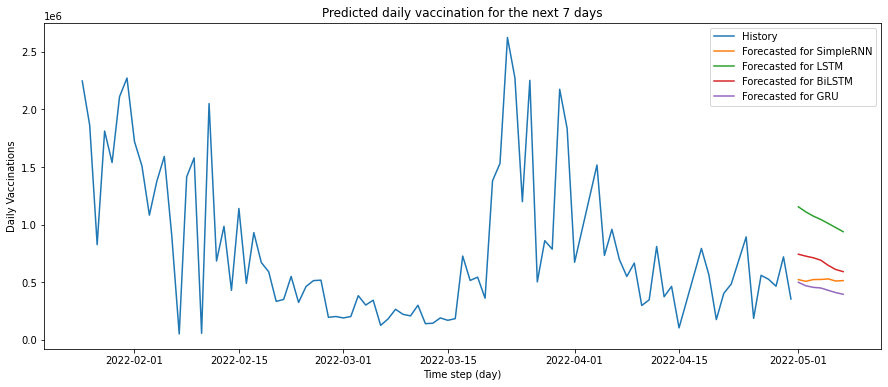

In [71]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,7)

In [72]:
#Forecasting 15 day vaccinations
new_data= create_dataset(test_scaled,30,15)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (15, 30, 1)
1/1 [==============================] - 0s 74ms/step
Forecasted for RNN :
[[522512.  ]
 [507493.94]
 [522974.72]
 [523707.  ]
 [528649.3 ]
 [510110.1 ]
 [513717.72]
 [507484.7 ]
 [508444.38]
 [509455.06]
 [509319.97]
 [513739.25]
 [511276.78]
 [511432.62]
 [509051.88]]
1/1 [==============================] - 0s 59ms/step
Forecasted for LSTM :
[[1154254.5 ]
 [1110110.2 ]
 [1073692.5 ]
 [1044517.8 ]
 [1009848.4 ]
 [ 974104.9 ]
 [ 938298.2 ]
 [ 904661.06]
 [ 879709.5 ]
 [ 858815.94]
 [ 842839.44]
 [ 824325.1 ]
 [ 806517.6 ]
 [ 792666.44]
 [ 780839.4 ]]
1/1 [==============================] - 0s 60ms/step
Forecasted for Bi-LSTM :
[[742964.9 ]
 [725966.25]
 [711957.25]
 [690891.56]
 [646183.9 ]
 [610364.25]
 [591735.06]
 [585123.5 ]
 [587078.25]
 [576951.2 ]
 [569299.06]
 [545755.9 ]
 [534011.75]
 [527503.8 ]
 [524369.  ]]
1/1 [==============================] - 0s 56ms/step
Forecasted for GRU :
[[498981.94]
 [468934.25]
 [455229.66]
 [449802.1 ]
 [429500.56]
 [409974.4

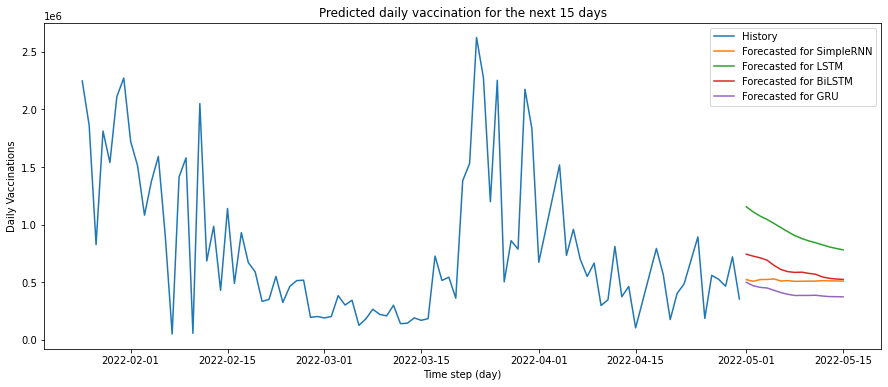

In [73]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,15)

In [74]:
#Forecasting 15 day vaccinations
new_data= create_dataset(test_scaled,30,30)
print('X_30.shape: ', new_data.shape) 

forecasted_rnn = forecasted(model_rnn,'RNN', new_data)
forecasted_lstm = forecasted(model_lstm,'LSTM', new_data)
forecasted_bilstm = forecasted(model_bilstm,'Bi-LSTM', new_data)
forecasted_gru = forecasted(model_gru,'GRU', new_data)

X_30.shape:  (30, 30, 1)
1/1 [==============================] - 0s 47ms/step
Forecasted for RNN :
[[ 522512.  ]
 [ 507493.94]
 [ 522974.72]
 [ 523707.  ]
 [ 528649.3 ]
 [ 510110.1 ]
 [ 513717.72]
 [ 507484.7 ]
 [ 508444.38]
 [ 509455.06]
 [ 509319.97]
 [ 513739.25]
 [ 511276.78]
 [ 511432.62]
 [ 509051.88]
 [ 511925.88]
 [ 509435.38]
 [ 512062.88]
 [ 511556.75]
 [ 512065.97]
 [ 509822.22]
 [ 511027.72]
 [ 513347.3 ]
 [ 548174.56]
 [ 530449.3 ]
 [ 530163.94]
 [ 653383.25]
 [ 883424.5 ]
 [1454872.9 ]
 [1730746.4 ]]
1/1 [==============================] - 0s 61ms/step
Forecasted for LSTM :
[[1154254.5 ]
 [1110110.2 ]
 [1073692.5 ]
 [1044517.8 ]
 [1009848.4 ]
 [ 974104.9 ]
 [ 938298.2 ]
 [ 904661.06]
 [ 879709.5 ]
 [ 858815.94]
 [ 842839.44]
 [ 824325.1 ]
 [ 806517.6 ]
 [ 792666.44]
 [ 780839.4 ]
 [ 769339.5 ]
 [ 761622.25]
 [ 753464.44]
 [ 743507.1 ]
 [ 735989.7 ]
 [ 728862.1 ]
 [ 723198.9 ]
 [ 735333.06]
 [ 751950.7 ]
 [ 771172.7 ]
 [ 785617.6 ]
 [ 834291.44]
 [ 909663.2 ]
 [1041229.8 ]
 

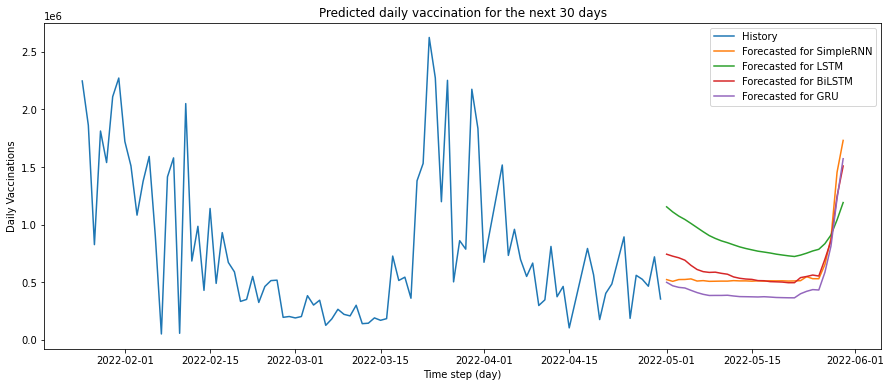

In [75]:
plot_multi_step(test_data, forecasted_rnn, forecasted_lstm, forecasted_bilstm,forecasted_gru,30)